## 프로젝트 : 모든 장르 간 편향성 측정해 보기

## WEAT 구현

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [131]:
def cos_sim(a,b):
    return dot(a,b.T) / norm(a) * norm(b)

def s(w, A, B): 
    c_a = cos_sim(w,A)
    c_b = cos_sim(w,B)
    
    mean_a = np.mean(c_a, axis = -1)
    mean_b = np.mean(c_b, axis = -1)
    
    return mean_a - mean_b

In [134]:
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X,s_Y], axis = 0))
    
    return (mean_X - mean_Y) / std_dev

## 직접 만드는 Word Embedding에 WEAT 적용

## 1. 형태소 분석기를 이용하여 명사 추출

In [4]:
from konlpy.tag import Okt

okt = Okt()
data_path = 'C:/users/juwon/practice_aiffel/gd_nlp/weat/'
tokenized = []

with open(data_path + 'synopsis.txt', 'r', encoding='UTF-8') as f:
    while True:
        line = f.readline()
        if not line : break
        words = okt.pos(line, stem= True, norm = True)
        res = []
        for w in words:
            if w[1] in ['Noun']:
                res.append(w[0])
        tokenized.append(res)
        

In [5]:
print(len(tokenized))

71156


## 2. Word2Vec을 활용하여 임베딩 모델 만들기 

In [105]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size =120, window=3, min_count = 3, workers=4, sg=0)
model.wv.most_similar(positive=['영화'])

[('작품', 0.8876355290412903),
 ('다큐멘터리', 0.8306227922439575),
 ('영화로', 0.8027042746543884),
 ('드라마', 0.7922249436378479),
 ('감동', 0.7640876770019531),
 ('코미디', 0.7625203132629395),
 ('영상', 0.7612444162368774),
 ('소설', 0.7557238936424255),
 ('버자이너', 0.748127281665802),
 ('형식', 0.7448681592941284)]

In [106]:
model.wv.most_similar(positive=['사랑'])

[('진심', 0.7137304544448853),
 ('첫사랑', 0.7096462845802307),
 ('우정', 0.7042750120162964),
 ('마음', 0.6850090026855469),
 ('연애', 0.6849740743637085),
 ('행복', 0.6841498017311096),
 ('애정', 0.6836258769035339),
 ('감정', 0.680023729801178),
 ('고백', 0.6789712309837341),
 ('재회', 0.6750574707984924)]

## 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

* WEAT score을 구하기 위해 단어셋(target, attribute)과 두 축을 정하겠습니다.    
* 두 축으로는 영화구분과 영화장르를 사용하겠습니다.    
* target인 영화구분에는 일반(상업)영화와 예술영화로 정하고, attribute에는 모든 장르로 정하겠습니다.

* 영화 구분

synopsis_art.txt : 예술영화   

synopsis_gen.txt : 일반영화(상업영화)   

그 외는 독립영화 등으로 분류됩니다.   

* 장르 구분   

synopsis_SF.txt: SF

synopsis_가족.txt: 가족

synopsis_공연.txt: 공연

synopsis_공포(호러).txt: 공포(호러)

synopsis_기타.txt: 기타

synopsis_다큐멘터리.txt: 다큐멘터리

synopsis_드라마.txt: 드라마

synopsis_멜로로맨스.txt: 멜로로맨스

synopsis_뮤지컬.txt: 뮤지컬

synopsis_미스터리.txt: 미스터리

synopsis_범죄.txt: 범죄

synopsis_사극.txt: 사극

synopsis_서부극(웨스턴).txt: 서부극(웨스턴)

synopsis_성인물(에로).txt: 성인물(에로)

synopsis_스릴러.txt: 스릴러

synopsis_애니메이션.txt: 애니메이션

synopsis_액션.txt: 액션

synopsis_어드벤처.txt: 어드벤처

synopsis_전쟁.txt: 전쟁

synopsis_코미디.txt: 코미디

synopsis_판타지.txt: 판타지

## 3.1 target 단어 셋 만들기

In [8]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def tokenize_txt(file_name):
    okt= Okt()
    result = []
    with open(data_path + file_name,'r', encoding='UTF-8') as f:
        print('{} 파일을 읽고 있습니다'.format(file_name))
        while True:
            line = f.readline()
            if not line : break
            words = okt.pos(line, stem = True, norm = True)
            for word in words:
                if word[1] in ['Noun']:
                    result.append((word[0]))
    return ' '.join(result)

In [9]:
art = tokenize_txt(art_txt)
gen = tokenize_txt(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다
synopsis_gen.txt 파일을 읽고 있습니다


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [67]:
vectorizer.vocabulary_['']

34194

In [12]:
vectorizer.get_feature_names_out()[11220]

'모임'

In [39]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i,j] for i,j in zip(m1.col, m1.data)]
w2 = [[i,j] for i,j in zip(m2.col, m2.data)]

w1.sort(key=lambda x : x[1], reverse =True)
w2.sort(key=lambda x : x[1], reverse =True)

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]],w1[i][1], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]],w2[i][1], end=', ')

예술영화를 대표하는 단어들:
그녀 0.3041128528402531, 자신 0.29468299693822975, 시작 0.29141881604906783, 위해 0.26077178436749193, 사랑 0.25460610935463046, 사람 0.2341143071060028, 영화 0.15649933929704138, 

C:\Users\juwon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


친구 0.15142172458056727, 남자 0.1338314164556391, 가족 0.11243289729335534, 이야기 0.10989408993511829, 마을 0.10481647521864418, 사건 0.09865080020578275, 마음 0.09792542667485787, 세상 0.09756273990939544, 아버지 0.09502393255115839, 아이 0.09393587225477108, 엄마 0.09266646857565256, 모든 0.09248512519292133, 여자 0.09085303474834036, 대한 0.08849557077283453, 서로 0.0861381067973287, 과연 0.08559407664913504, 다시 0.08251123914270432, 시간 0.08251123914270432, 아들 0.07960974501900484, 소녀 0.07725228104349899, 아내 0.07271869647521853, 다른 0.07108660603063757, 사이 0.06927317220332539, 영화제 0.06927317220332539, 세계 0.06854779867240052, 사실 0.06818511190693807, 하나 0.06637167807962589, 점점 0.06310749719046396, 남편 0.06220078027680787, 감독 0.061475406745883004, 여행 0.060568689832226914, 인생 0.060024659684033255, 발견 0.059117942770377165, 모두 0.05875525600491473, 순간 0.05857391262218351, 우리 0.05766719570852742, 가장 0.05657913541214011, 마지막 0.054040328053903054, 생활 0.05367764128844062, 아빠 0.05367764128844062, 모습 0.05295226775751574, 통해 0.0529

In [36]:
n = 15
w1_ = []
w2_ = []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

target_art = []
target_gen = []

for i in range(100):
    if (w1_[i] not in w2_) & (w1_[i] in model.wv) : target_art.append(w1_[i])
    if len(target_art) == n : break

for i in range(100):
    if (w2_[i] not in w1_) & (w2_[i] in model.wv) : target_gen.append(w2_[i])
    if len(target_gen) == n : break

In [37]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## 3.2 attribute 단어 셋 만들기

In [42]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [43]:
genre = []
for file_name in genre_txt:
    genre.append(tokenize_txt(file_name))

synopsis_SF.txt 파일을 읽고 있습니다
synopsis_family.txt 파일을 읽고 있습니다
synopsis_show.txt 파일을 읽고 있습니다
synopsis_horror.txt 파일을 읽고 있습니다
synopsis_etc.txt 파일을 읽고 있습니다
synopsis_documentary.txt 파일을 읽고 있습니다
synopsis_drama.txt 파일을 읽고 있습니다
synopsis_romance.txt 파일을 읽고 있습니다
synopsis_musical.txt 파일을 읽고 있습니다
synopsis_mystery.txt 파일을 읽고 있습니다
synopsis_crime.txt 파일을 읽고 있습니다
synopsis_historical.txt 파일을 읽고 있습니다
synopsis_western.txt 파일을 읽고 있습니다
synopsis_adult.txt 파일을 읽고 있습니다
synopsis_thriller.txt 파일을 읽고 있습니다
synopsis_animation.txt 파일을 읽고 있습니다
synopsis_action.txt 파일을 읽고 있습니다
synopsis_adventure.txt 파일을 읽고 있습니다
synopsis_war.txt 파일을 읽고 있습니다
synopsis_comedy.txt 파일을 읽고 있습니다
synopsis_fantasy.txt 파일을 읽고 있습니다


In [44]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)
print(X.shape)

(21, 42191)


In [122]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)]for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse = True)

attribute = []
for i in range(len(w)):
    attr=[]
    print(genre_name[i], end=': ')
    j=0
    while len(attr) < 25 :
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]],w[i][j][1], end=', ')
        j+=1
    attribute.append(attr)
    print()
    print()

SF: 위해 0.2605304898004592, 자신 0.2578306919786928, 지구 0.24311760962006135, 시작 0.22678301702837897, 사람 0.19303554425629876, 인류 0.18855687324312367, 인간 0.1484888801971529, 미래 0.1300150976062273, 우주 0.12544212077819988, 그녀 0.1147414074250727, 로봇 0.11390587236395597, 세계 0.11204160960330628, 모든 0.1073649134285495, 박사 0.10210939604042577, 우주선 0.0932292017947141, 외계 0.08652299913841272, 존재 0.0836937324747589, 세상 0.08193638130073516, 발견 0.0809939346529925, 행성 0.08022047596289353, 정체 0.07829413683122607, 친구 0.07694423792034287, 비밀 0.07628559638344307, 사실 0.07628559638344307, 기억 0.07540645895865461, 

가족: 엄마 0.24746109893787335, 아빠 0.22621239996056924, 가족 0.20313690840925253, 영화제 0.20047121104243398, 자신 0.19410704561251546, 위해 0.17501454932275984, 친구 0.15273997031804495, 아주르 0.1513733734073891, 아버지 0.1495578876030857, 시작 0.1463758048881264, 그녀 0.14319372217316714, 아들 0.12410122588341152, 마을 0.12091914316845224, 국제 0.12091914316845224, 낙타 0.11706413824961394, 할머니 0.10945761288414642, 씨제이 0.1081238

성인물(에로): 그녀 0.46502280632613247, 남편 0.3221454313853036, 마사지 0.23654977735685062, 자신 0.2247688438246392, 섹스 0.1676092073246732, 관계 0.16303701710353777, 영화 0.14781368116917132, 정사 0.14648772184879974, 남자 0.14499702033781525, 위해 0.1388968220711758, 시작 0.12575793349687536, 여자 0.11512926725396781, 유부녀 0.10909944489652736, 마음 0.09919722124974287, 사랑 0.08774900583550632, 에피소드 0.08475904581802061, 그린 0.08377710072498551, 아내 0.08164880756886685, 다시 0.08004528249360439, 자위 0.07929060070351401, 이야기 0.0780809810827184, 회사 0.07732030082695604, 친구 0.07648710134324883, 불륜 0.07447576366656004, 사실 0.07415237826094641, 

스릴러: 자신 0.32226018371573545, 그녀 0.2878092063920043, 사건 0.28317127650949214, 시작 0.2562291438452507, 위해 0.2339795543236743, 사람 0.2102945074136091, 살인 0.1742592470827644, 남자 0.15072302579132393, 발견 0.11340113369061515, 아내 0.10765930413665996, 경찰 0.10298375641380596, 친구 0.10191747458270475, 모든 0.0946407979846048, 사실 0.08938297587434899, 살해 0.0872610455109348, 가족 0.0871296235413822, 형사 0.085

## 4. embedding model과 단어 셋으로 WEAT Score 구하기

In [114]:
freq_dic = {}
for word, _ in model.wv.key_to_index.items():
    freq = model.wv.get_vecattr(word,'count')
    freq_dic.update({word:freq})

In [123]:
common_list = ['자신','그녀','위해','시작','사람','국제','영화제','애니메이션','남자','여자','사건','감독','발견']

In [128]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)]for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse = True)

attribute = []
for i in range(len(w)):
    attr=[]
    print(genre_name[i], end=': ')
    j=0
    while len(attr) < 15 :
        if (vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv) & \
        (vectorizer.get_feature_names_out()[w[i][j][0]] not in common_list):
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j+=1
    attribute.append(attr)
    print()
    print()

SF: 지구, 인류, 인간, 미래, 우주, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 행성, 정체, 

가족: 엄마, 아빠, 가족, 친구, 아주르, 아버지, 아들, 마을, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 학교, 

공연: 오페라, 사랑, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 

공포(호러): 친구, 공포, 죽음, 마을, 가족, 악령, 좀비, 영화, 사실, 소녀, 하나, 살인, 이야기, 비밀, 아이, 

기타: 서울, 단편, 영화, 이야기, 사랑, 뉴미디어, 페스티벌, 대한, 독립, 친구, 작품, 엄마, 통해, 아시아나, 다른, 

다큐멘터리: 영화, 다큐, 다큐멘터리, 이야기, 대한, 서울, 우리, 세계, 통해, 여성, 가족, 한국, 작품, 환경, 사회, 

드라마: 사랑, 영화, 친구, 이야기, 엄마, 아버지, 가족, 단편, 서울, 대한, 아들, 마음, 아이, 남편, 서로, 

멜로로맨스: 사랑, 남편, 친구, 섹스, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 영화, 점점, 

뮤지컬: 뮤지컬, 사랑, 에스메랄다, 음악, 충무로, 모차르트, 영화, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 

미스터리: 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 아이, 민혁, 사실, 의문, 미스터리, 형사, 하나, 비밀, 

범죄: 경찰, 범죄, 조직, 살인, 마약, 형사, 모든, 살해, 수사, 한길수, 범인, 계획, 은행, 작전, 아버지, 

사극: 조선, 신기전, 사랑, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 

서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 개릿, 아이, 무법자, 프린트, 마적, 태구, 현상금, 분노, 

성인물(에로): 남편, 마사지, 섹스, 관계, 영화, 정사, 유부녀, 마음, 사랑, 에피소드, 그린, 아내, 다시, 자위

In [121]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [136]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attribute[i]])
        B = np.array([model.wv[word] for word in attribute[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [137]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.8246204
SF 공연 -0.107604735
SF 공포(호러) -0.80804527
SF 기타 0.28895733
SF 다큐멘터리 0.48416555
SF 드라마 -0.7649532
SF 멜로로맨스 -0.8635448
SF 뮤지컬 0.028582415
SF 미스터리 -0.7763318
SF 범죄 -0.17782462
SF 사극 -0.2117162
SF 서부극(웨스턴) -0.1701159
SF 성인물(에로) -0.6531339
SF 스릴러 -0.7436375
SF 애니메이션 0.16000596
SF 액션 -0.5230107
SF 어드벤처 -0.9094462
SF 전쟁 0.109871134
SF 코미디 -1.044537
SF 판타지 -0.44499835
가족 공연 1.0354536
가족 공포(호러) 0.37365043
가족 기타 0.71323735
가족 다큐멘터리 0.7753707
가족 드라마 0.039101537
가족 멜로로맨스 -0.4488423
가족 뮤지컬 1.0159457
가족 미스터리 0.07087991
가족 범죄 0.7517941
가족 사극 0.98022985
가족 서부극(웨스턴) 1.1477699
가족 성인물(에로) 0.011953147
가족 스릴러 -0.05539377
가족 애니메이션 0.70400196
가족 액션 0.59249395
가족 어드벤처 0.4320294
가족 전쟁 1.034723
가족 코미디 -0.26177162
가족 판타지 0.6800401
공연 공포(호러) -0.5824932
공연 기타 0.39789054
공연 다큐멘터리 0.53230387
공연 드라마 -0.88250506
공연 멜로로맨스 -0.9326885
공연 뮤지컬 0.61355156
공연 미스터리 -0.6660126
공연 범죄 -0.09781527
공연 사극 -0.5826984
공연 서부극(웨스턴) -0.22469538
공연 성인물(에로) -0.823668
공연 스릴러 -0.67786914
공연 애니메이션 0.27215105
공연 액션 -0.35639358

## WEAT Score가 0.8 이상의 경우

In [140]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if (matrix[i][j]<=-0.8) or (matrix[i][j]>=0.8) :
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.8246204
SF 공포(호러) -0.80804527
SF 멜로로맨스 -0.8635448
SF 어드벤처 -0.9094462
SF 코미디 -1.044537
가족 공연 1.0354536
가족 뮤지컬 1.0159457
가족 사극 0.98022985
가족 서부극(웨스턴) 1.1477699
가족 전쟁 1.034723
공연 드라마 -0.88250506
공연 멜로로맨스 -0.9326885
공연 성인물(에로) -0.823668
공연 코미디 -1.1325139
기타 드라마 -0.9269813
기타 멜로로맨스 -0.8181709
기타 성인물(에로) -0.8156515
기타 코미디 -0.85693026
다큐멘터리 드라마 -0.9611234
다큐멘터리 멜로로맨스 -0.8561485
다큐멘터리 성인물(에로) -0.84165704
다큐멘터리 어드벤처 -0.88427895
다큐멘터리 코미디 -0.92656857
드라마 뮤지컬 1.0098506
드라마 사극 0.80914515
드라마 서부극(웨스턴) 0.850666
드라마 애니메이션 0.81176484
드라마 전쟁 0.8411996
드라마 판타지 0.8392505
멜로로맨스 뮤지컬 0.95761925
멜로로맨스 범죄 0.8564802
멜로로맨스 사극 0.8988525
멜로로맨스 서부극(웨스턴) 0.94730765
멜로로맨스 전쟁 0.9146628
멜로로맨스 판타지 0.8117406
뮤지컬 성인물(에로) -0.910166
뮤지컬 어드벤처 -0.97475165
뮤지컬 코미디 -1.1795354
미스터리 범죄 0.82687676
범죄 스릴러 -1.0084763
사극 코미디 -1.1149752
서부극(웨스턴) 코미디 -1.1750349
애니메이션 코미디 -0.8030081
어드벤처 전쟁 0.8550388
어드벤처 코미디 -0.8745768
어드벤처 판타지 0.9111149
전쟁 코미디 -1.0743554
코미디 판타지 1.031009


<AxesSubplot: >

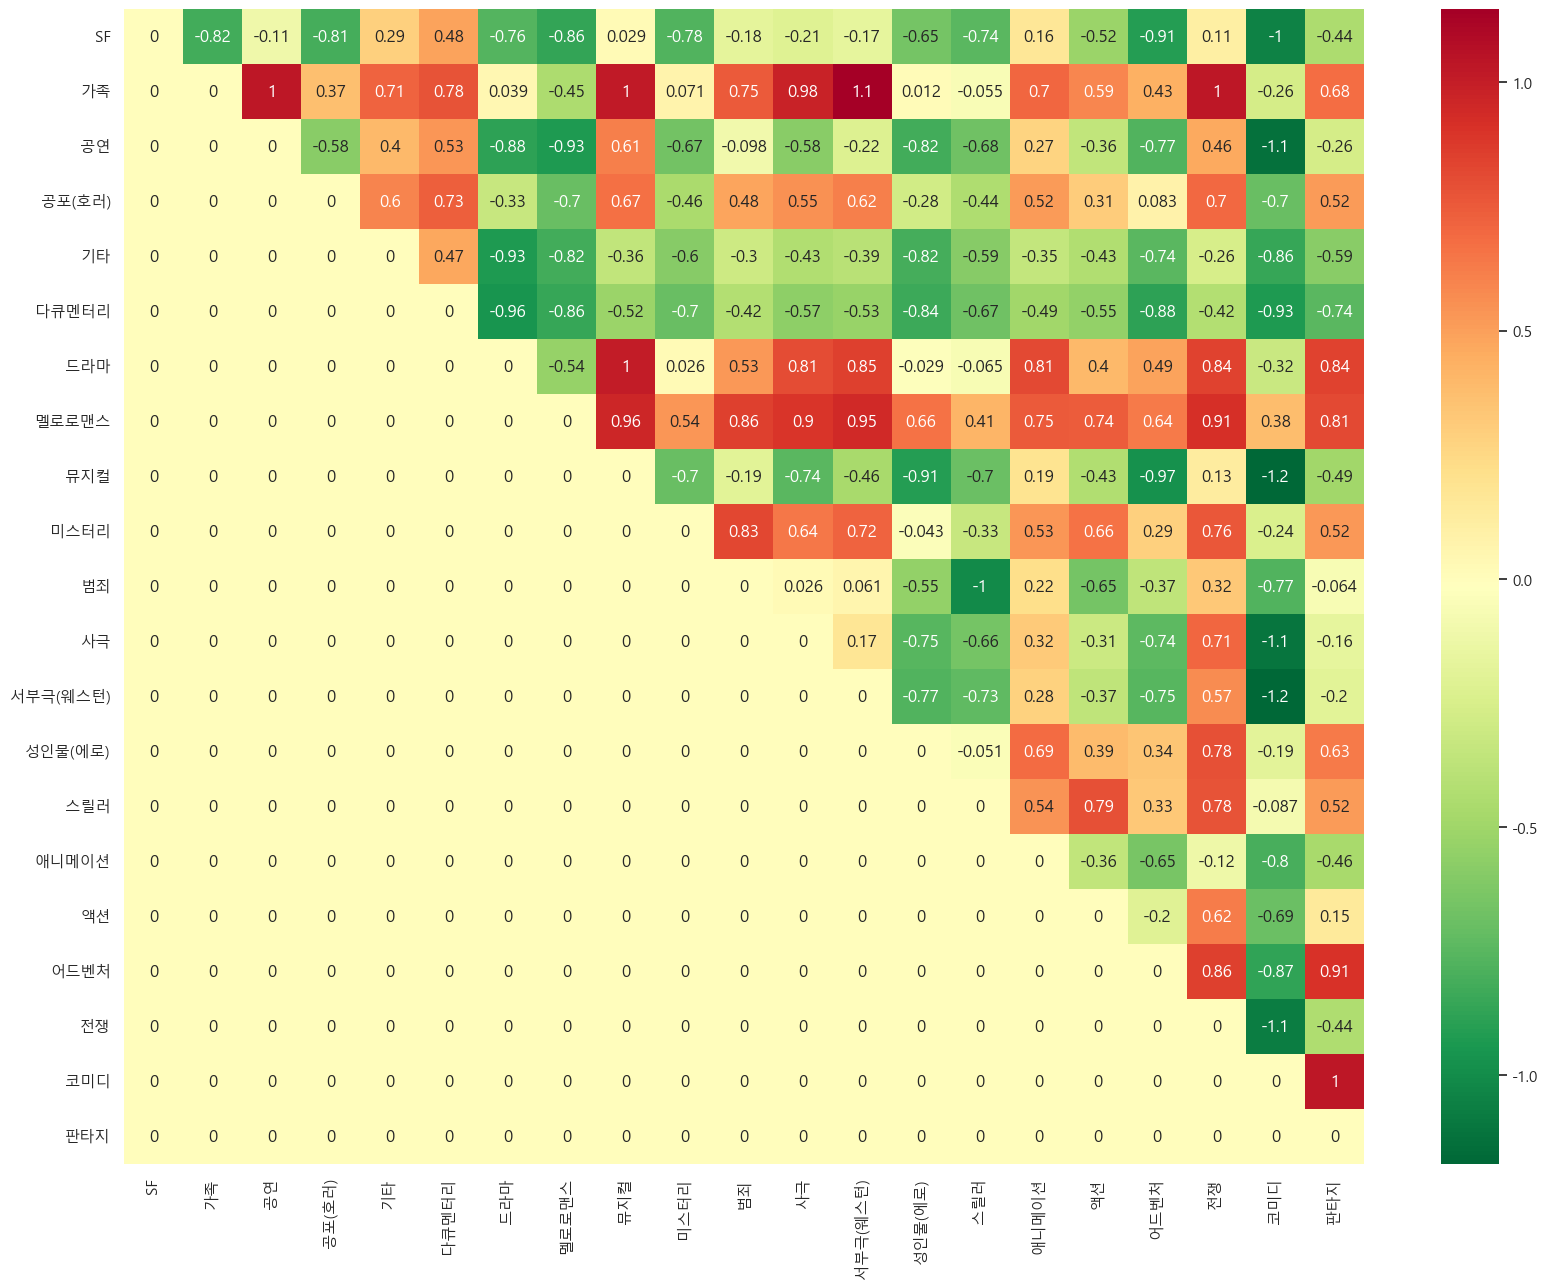

In [155]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='Malgun Gothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,15))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

## 평가

1. 기존의 단어와 tfidf 값까지 같이 출력하였다. 단어:반도수 사전을 만들어 값들과 비교해보았다.   
    -> 일정 빈도수 이상의 단어를 제외시키기 위함.
    
    
2. 빈도수가 많더라도 vectorizer안에서 불용어처리를 하여 리스트에 담기지 않은 단어도 보였다.   


3. attribute를 대표하지 않음에도 단어 빈도수가 높은 단어들은 tfidf값이 높아져 리스트에 포함된 것을 발견했다.    
    -> 모든 문서에서 자주 사용되는 단어임에도 tfidf값이 높아진 것을 보아 idf값이 낮아도 빈도수가 상당히 많거나 txt파일을 영화 단위가아닌 시놉시스 단위로 묶어서 생긴 문제라고 생각함.

따라서 문서가 많지 않기 때문에 문서별로 상위에 포함된 단어들을 제외시키기로함.

WEAT Score 결과로 sf,액션,전쟁,판타지,공연,기타,사극 영화들은 일반(상업)영화 쪽에 편향이 있었고,      
가족,드라마, 멜로로맨스 등이 예술 영화쪽으로 편향이 있었다.   
의외로 성인물(에로) 다른것들과 비교해서 예술영화쪽으로 편향이 있었다.   